=== iteration 0 ===
New shortest distance= 17.3 Iteration= 2
pheromone [0.5, 0.5, 0.5, 0.5, 0.48999999999999994, 0.5077619893428064, 0.48999999999999994, 0.8659342776414211, 0.8659342776414211, 0.8659342776414211, 0.6337849785278363, 0.6480381289856728, 0.5249075975359342, 0.48999999999999994, 0.48999999999999994, 0.5, 0.5]
New shortest distance= 15.1 Iteration= 12
pheromone [0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.596863884511204, 0.4964642865301607, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5]
=== iteration 20 ===
=== iteration 40 ===
=== iteration 60 ===
=== iteration 80 ===
New shortest distance= 14.899999999999997 Iteration= 87
pheromone [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
=== iteration 100 ===
=== iteration 120 ===
=== iteration 140 ===
=== iteration 160 ===
=== iteration 180 ===
pheromone [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 

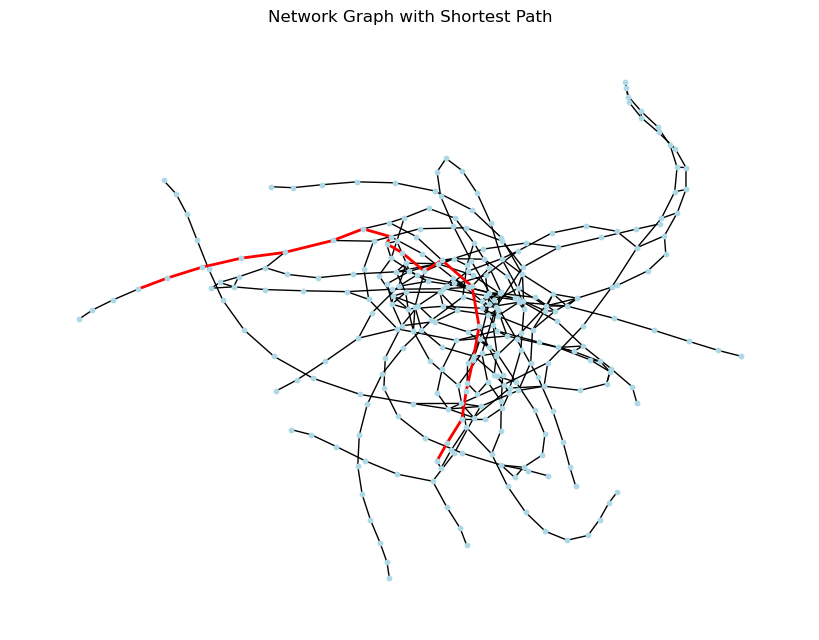

In [25]:
import os
import time
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
from IPython.display import display
import tkinter as tk
from tkinter import ttk
import json
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Load the data from the JSON file
file_path = 'stations.json'
with open(file_path, 'r', encoding='utf-8') as file:
    station_data = json.load(file)


# Lines to be processed
lines = ['A', 'C', 'E', 'F', 'G', 'H', 'I', 'M', 'Mb', 'N', 'S', 'T', 'Y', 'Z']


# Create the network graph
graph = nx.Graph()
for station_id, station_info in station_data['stations'].items():
    graph.add_node(station_id, name_en=station_info['name_en'], name_jp=station_info['name_jp'])
    for connection in station_info['connections']:
        graph.add_edge(station_id, connection['target_id'], distance=connection['distance'])
        
# Load the station data
with open('stations.json', 'r', encoding='utf-8') as file:
    station_data = json.load(file)

# Global variables to store selected stations
start_station = ""
final_station = ""

def on_select(event):
    global start_station, final_station
    selected_item = tree.selection()[0]  # get selected item
    station_id, station_name_en = tree.item(selected_item)['values']
    # Update the global variables with the selected stations in English
    if not start_station:
        start_station = station_name_en
        start_label.config(text=f"From: {start_station}")
    elif not final_station:
        final_station = station_name_en
        final_label.config(text=f"To: {final_station}")
        confirm_button.config(state=tk.NORMAL)  # Enable the Confirm button

def confirm_selection():
    global start_station, final_station
    root.destroy()  # Close the GUI

# Setup the main window
root = tk.Tk()
root.title("Station Selector")

# Instructions label
instruction_label = tk.Label(root, text="Select the station off from where you will be taking the train and later the destination.", font=("Helvetica", 12))
instruction_label.pack(pady=10)

# Labels for selected stations
start_label = tk.Label(root, text="From: ", font=("Helvetica", 12))
start_label.pack()
final_label = tk.Label(root, text="To: ", font=("Helvetica", 12))
final_label.pack()

# Create a frame to hold the Treeview and Scrollbar
tree_frame = tk.Frame(root)
tree_frame.pack(expand=True, fill='both')

# Setup the Treeview
tree = ttk.Treeview(tree_frame, columns=('Station ID', 'Station Name (EN)'), show='headings')
tree.heading('Station ID', text='Station ID')
tree.heading('Station Name (EN)', text='Station Name (EN) - Click to Select')
tree.column('Station ID', width=100)
tree.column('Station Name (EN)', width=250)

# Bind the on_select function to the Treeview's selection event
tree.bind('<<TreeviewSelect>>', on_select)

# Populate the Treeview with station data
for line in ['A', 'C', 'E', 'F', 'G', 'H', 'I', 'M', 'Mb', 'N', 'S', 'T', 'Y', 'Z']:
    for station_id, info in station_data['stations'].items():
        if station_id.startswith(line):
            tree.insert('', 'end', values=(station_id, info['name_en']))

# Create a Scrollbar and set it to work with the Treeview
scrollbar = ttk.Scrollbar(tree_frame, orient="vertical", command=tree.yview)
tree.configure(yscrollcommand=scrollbar.set)

# Pack the Treeview and Scrollbar into the frame
tree.pack(side="left", expand=True, fill='both')
scrollbar.pack(side="right", fill='y')

# Confirm button (initially disabled)
confirm_button = tk.Button(root, text="Confirm", command=confirm_selection, state=tk.DISABLED)
confirm_button.pack(pady=10)

# Start the application
root.mainloop()

# Fetching the stations that the user selected
start = start_station
final = final_station

# Initialize pheromone levels for all edges in both directions
pheromone = {edge: 1.0 for edge in graph.edges()}
pheromone2 = {edge: 0.0 for edge in graph.edges()}
pheromone.update({(v, u): pheromone[(u, v)] for u, v in graph.edges() if (v, u) not in pheromone})
pheromone2.update({(v, u): pheromone2[(u, v)] for u, v in graph.edges() if (v, u) not in pheromone2})

# Placeholder for the shortest path
shortest_path = None
shortest_distance = float('inf')
fewest_lineswaps = 0

def find_station_id_by_name(graph, station_name, name_attribute='name_en'):
    for node_id, attributes in graph.nodes(data=True):
        if attributes.get(name_attribute) == station_name:
            return node_id
    return None

def line_heuristic(node1, node2):
    line1 = get_line(node1)
    line2 = get_line(node2)

    # Assign a high heuristic value if nodes are on the same line, lower otherwise
    return 2.0 if line1 == line2 else 1.0

def get_line(station_id):
    # Extract the line from the station_id
    for line in lines:
        if station_id.startswith(line):
            return line
        
def get_station_names(station_ids):
    return [station_data.get(station_id, {}).get('name_en', 'Unknown Station') for station_id in station_ids]
        

def ant_colony_optimization_specific(graph, pheromone, number_of_ants, number_of_iterations, evaporation_rate, start_name, end_name, tconst,max_pheromone,transfer_penalty):
    global shortest_path, shortest_distance, distance_table,iteration_table
    edge=[1,1]
    start_node = find_station_id_by_name(graph, start_name, name_attribute='name_en')
    end_node = find_station_id_by_name(graph, end_name, name_attribute='name_en')
    found=0
    visited_nodes=None
    pheromone_visualisation= []
    fewest_lineswaps=0
    distance_table=[]
    iteration_table=[]
    start_time = time.time()
    solution_time=0
    shortest_edge_path=[]
    for iteration in range(number_of_iterations):
       
        if iteration % 20 == 0:
                print("=== iteration {} ===".format(iteration))
                if found==4:
                    found=0
        for ant in range(number_of_ants):
            current_node = start_node
            visited_nodes = [current_node]
            edge_path= []
            path_distance = 0
            steps=0
            lineswaps=0

            while current_node != end_node and steps < 30 and visited_nodes.count(edge[1])<2:
                steps=+1
                possible_edges = [(edge, pheromone[edge])  for edge in graph.edges(current_node)] #if edge[1] not in visited_nodes]
                possible_edges2 = [edge  for edge in graph.edges(current_node)]
                pheromone_edges = [pheromone[edge] for edge in graph.edges(current_node)]
                if possible_edges:
                    pheromone_probability = ([prob**alpha for  prob in pheromone_edges])
                    heuristic_probability= ([float(visited_nodes.count(node[1])+1)**beta1 for node in possible_edges2])
                    sum_count=sum([pheromone*count for  pheromone,count in zip(pheromone_probability,heuristic_probability)])
                    probability = [pheromone * (1 / (heuristic))/sum_count for pheromone, heuristic in zip(pheromone_probability, heuristic_probability)]
                    
                    #Diagnostic tool to check pheromone levels and probability underway
                    if iteration % 100 ==0 and iteration!=0 and ant ==1000:
                        print('')
                        print('visited nodes={}',format(visited_nodes))
                        print('possible edges={}',format(possible_edges))
                        print('probability={}',format(probability))
                        print('heuristic probability={}',format(heuristic_probability))
                        print('')
                    edge_choice = random.choices(possible_edges, weights=probability)[0]
                    edge,_ = edge_choice
                    if visited_nodes.count(edge[1])>2:
                        print('break')
                        break
                    next_node = edge[1]
                    if next_node[0] != current_node[0]:
                        lineswaps += 1
                    path_distance += graph.get_edge_data(*edge)['distance']
                    visited_nodes.append(next_node)
                    edge_path.append(edge)
                    current_node = next_node
                else:
                    break
           
            if path_distance < shortest_distance and end_node in visited_nodes:
                shortest_path = visited_nodes
                shortest_distance = path_distance
                print('New shortest distance=',path_distance, 'Iteration=',iteration)
                distance_table.append(shortest_distance)
                iteration_table.append(iteration)
                shortest_edge_path = edge_path
                fewest_lineswaps = lineswaps
                solution_time = time.time()
                print('pheromone',[pheromone[edge] for edge in shortest_edge_path])

            #Calculating pheromones deposited by individual ants
            for edge in graph.edges():
                if end_node in visited_nodes and edge in edge_path or (edge[1], edge[0]) in edge_path:
                    #pheromone update
                    found+=1
                    pheromone2[edge] += 1.0 / (path_distance)
                            
        #Global pheromone update
        for edge in graph.edges():
            #evaporation rate
            pheromone[edge] *= (1.0 - evaporation_rate)
            pheromone[edge] += pheromone2[edge]
            pheromone[edge] = min(max(pheromone[edge],tconst/len(graph.edges(edge[0]))),max_pheromone)
            
            #applying pheromone update to reverse edges
            reverse_edge = (edge[1], edge[0])
            pheromone[reverse_edge] = pheromone[edge]   
            
    print('pheromone',[pheromone[edge] for edge in shortest_edge_path])
    print("Station number:",shortest_path )
    from_id_to_names = [station_data['stations'][station_id]['name_en'] for station_id in shortest_path]
    print(from_id_to_names)
    print("Shortest Distance:", shortest_distance,'Found in iteration=',iteration_table[-1])
    print('Amount of lineswaps:', fewest_lineswaps)
    print('Solution found in',(solution_time-start_time),'seconds')
    
start_name=start
end_name= final

# Ant colony optimization parameters
number_of_ants =30
number_of_iterations = 200
evaporation_rate = 0.3
alpha=1
beta1=10
tconst=1
max_pheromone=1.5

#adds a penalty to pheromone update for each transfer
transfer_penalty=0

# Run the ant colony optimization for the path from 'Ensjø' to 'Majorstuen'
ant_colony_optimization_specific(graph, pheromone, number_of_ants, number_of_iterations, evaporation_rate,start_name,end_name,tconst,max_pheromone,transfer_penalty)

with open('stations.json', 'r', encoding='utf-8') as file:
    station_data = json.load(file)['stations']


# Fetching the station names based on the station ids
station_names = get_station_names(shortest_path)

def draw_graph_with_shortest_path():
    pos = nx.spring_layout(graph, seed=1)
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    nx.draw(graph, pos, with_labels=False, node_size=10, node_color='lightblue')

    if shortest_path:
        path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title("Network Graph with Shortest Path")

# Create a Tkinter window
window = tk.Tk()
window.title("Graph Viewer")

# Create a main frame that will hold both the graph canvas and the Listbox
main_frame = tk.Frame(window)
main_frame.pack(fill='both', expand=True)

# Call the function to draw the graph
draw_graph_with_shortest_path()

# Embed the Matplotlib figure in the Tkinter window on the left side of the main frame
canvas = FigureCanvasTkAgg(plt.gcf(), master=main_frame)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# Create a Listbox to display the shortest path with station names on the right side of the main frame
listbox = tk.Listbox(main_frame)
listbox.pack(side=tk.LEFT, fill=tk.BOTH, expand=False)

# Insert the shortest path with station names into the Listbox
for station_id, station_name in zip(shortest_path, station_names):
    listbox.insert(tk.END, f"{station_id}: {station_name}")

# Run the Tkinter main loop
window.mainloop()

    